In [18]:
import random
import pandas as pd
import numpy as np
import os
from PIL import Image
import cv2

import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision import utils
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
from tqdm.auto import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


train=pd.read_csv('train.csv', encoding='cp949')
test=pd.read_csv('test.csv', encoding='cp949')
sample_submission=pd.read_csv('sample_submission.csv', encoding='cp949')

Configuration
===============

In [19]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':5,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':64,
    'SEED':41
}

In [20]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) 

EDA & Preprocessing
=====

In [21]:
df = train.sample(frac=1)
train_len = int(len(df) * 0.8)
train_df = df[:train_len]
val_df = df[train_len:]


In [22]:
(train_df.shape, val_df.shape)

((52396, 62), (13100, 62))

In [23]:
def get_labels(df):
    return df.iloc[:,2:].values

train_labels = get_labels(train_df)
val_labels = get_labels(val_df)

In [24]:
(train_labels.shape, val_labels.shape)

((52396, 60), (13100, 60))

In [25]:
train_outlier=train_df[train_df.iloc[:,2:].sum(axis=1)>=10]
train_outlier_labels=get_labels(train_outlier)
train_outlier.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2779 entries, 49900 to 31644
Data columns (total 62 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   img_id                   2779 non-null   object
 1   img_path                 2779 non-null   object
 2   airplane                 2779 non-null   int64 
 3   airport                  2779 non-null   int64 
 4   bare soil                2779 non-null   int64 
 5   baseball diamond         2779 non-null   int64 
 6   basketball court         2779 non-null   int64 
 7   beach                    2779 non-null   int64 
 8   bridge                   2779 non-null   int64 
 9   buildings                2779 non-null   int64 
 10  cars                     2779 non-null   int64 
 11  chaparral                2779 non-null   int64 
 12  cloud                    2779 non-null   int64 
 13  containers               2779 non-null   int64 
 14  crosswalk                2779 non-null  

In [26]:
class CustomDataset():
    def __init__(self, img_path_list, label_list, aug_mode='normal', mode='train'):
        self.img_path_list=img_path_list
        self.label_list=label_list
        self.aug_mode=aug_mode
        self.mode=mode
        
        self.kernel_sharpening=np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
        
        if self.aug_mode=='normal' or self.mode=='test':
            self.transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            
        if self.aug_mode=='rotate':
            self.transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                transforms.RandomRotation([-180, 180]),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            
        if self.aug_mode=='flip':
            self.transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                transforms.RandomHorizontalFlip(p=1),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            
        
        
    def __getitem__(self, index):
            img_path=self.img_path_list[index]
            
            image=cv2.imread(img_path, cv2.IMREAD_COLOR)
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LANCZOS4)

            # image=cv2.medianBlur(image,3)
            # image=cv2.filter2D(image,-1, self.kernel_sharpening)
            
            
            if self.transform is not None:
                image=self.transform(image)
                
            if self.label_list is not None:
                label = torch.tensor(self.label_list[index], dtype=torch.float32)
                return image,label
            else:
                return image
            
    def __len__(self):
        return len(self.img_path_list)   

def calculate_norm(dataset):
    # dataset의 axis=1, 2에 대한 평균 산출
    mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()

    # dataset의 axis=1, 2에 대한 표준편차 산출
    std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()
    
    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)

transform_custom = transforms.Compose([
    transforms.ToTensor(),
])

In [27]:
all_datasets=[]
all_validsets=[]

for mode in ['normal', 'flip']:
    d_set=CustomDataset(train_df['img_path'].values, train_labels, aug_mode=mode)
    all_datasets.append(d_set)
    
    
    
train_dataset=torch.utils.data.ConcatDataset(all_datasets)
train_loader=DataLoader(train_dataset, batch_size=CFG["BATCH_SIZE"],shuffle=True,num_workers=0)

train_outlier_dataset=CustomDataset(train_outlier['img_path'].values, train_outlier_labels, aug_mode='normal')

val_dataset=CustomDataset(val_df['img_path'].values, train_labels, mode='test')
val_loader=DataLoader(val_dataset, batch_size=CFG["BATCH_SIZE"],shuffle=False,num_workers=0)

In [28]:
def imshow(img, title=None):
    
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

num_show_img = 5

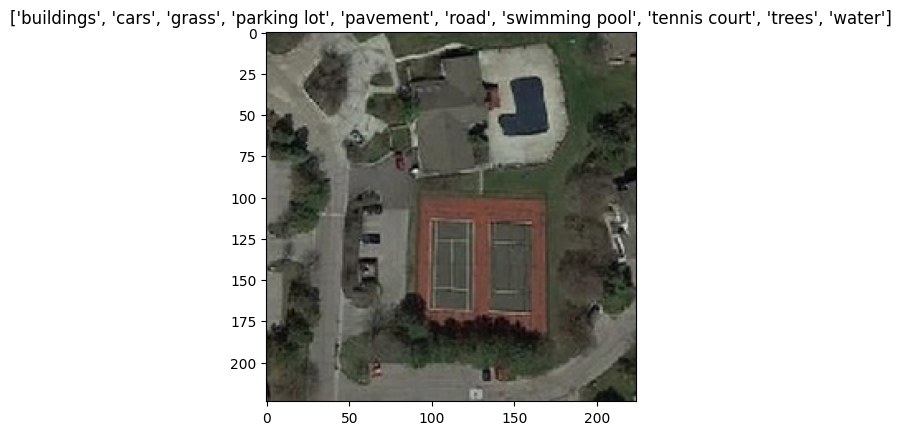

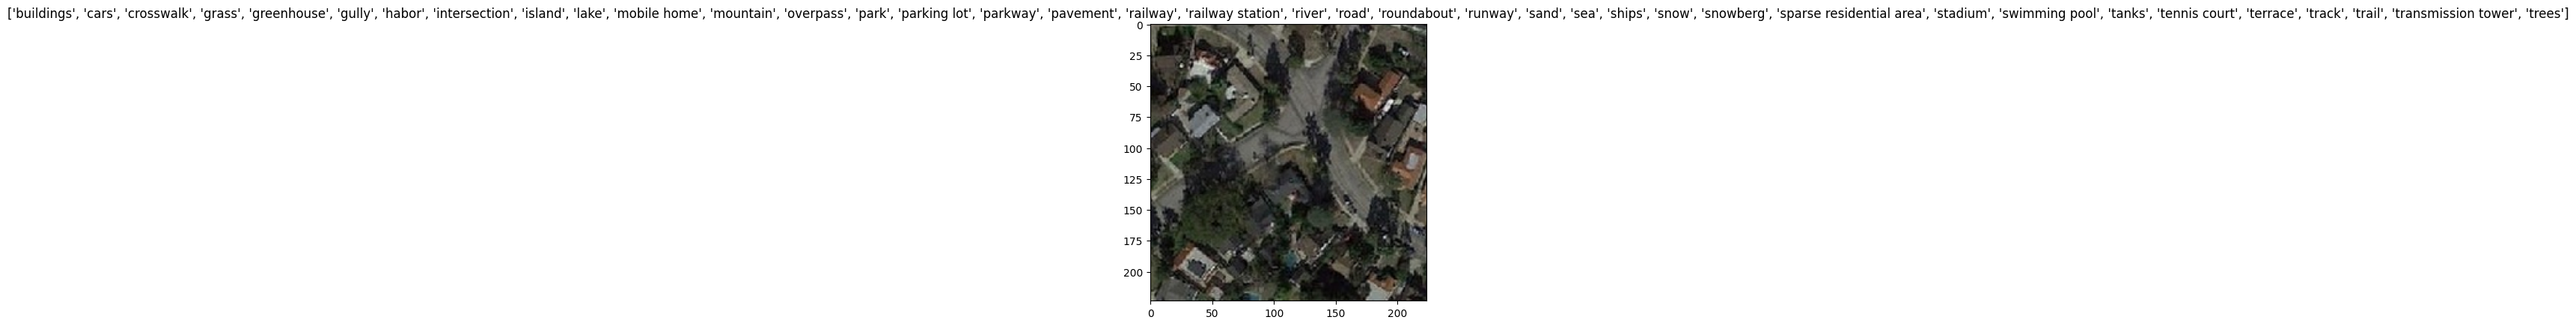

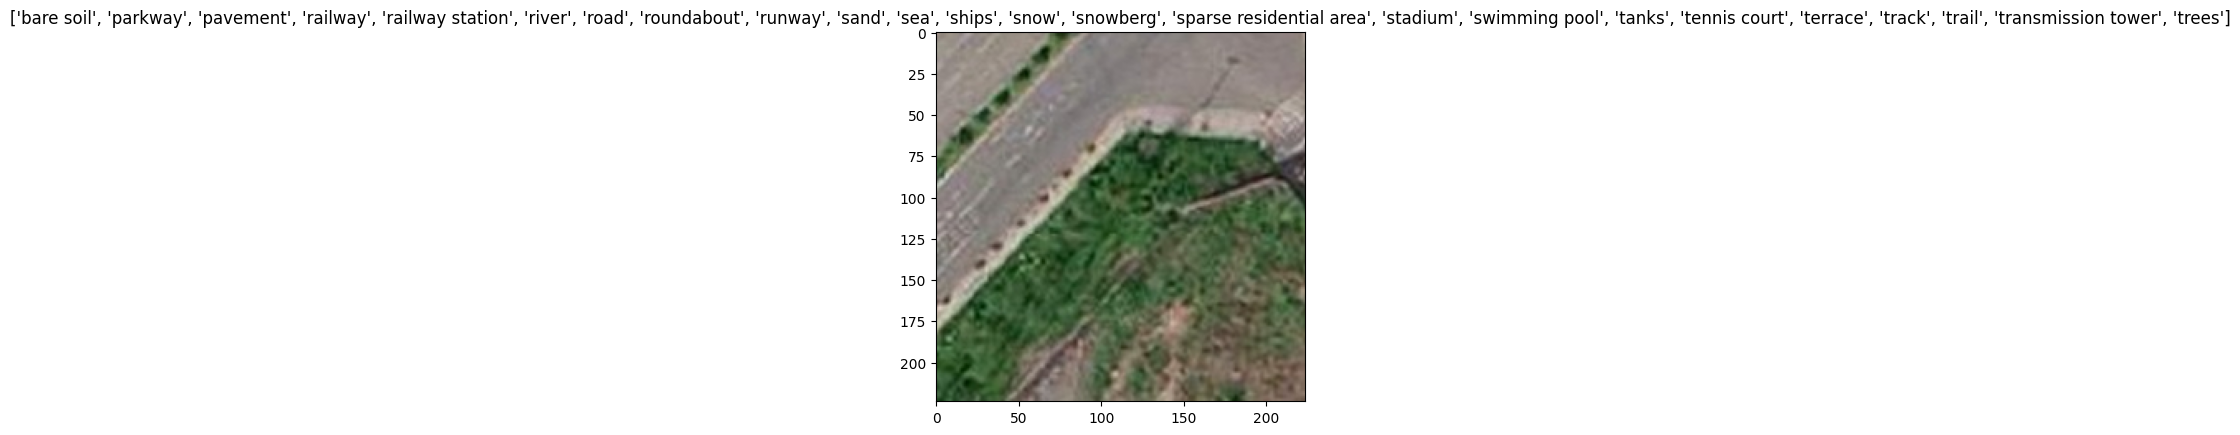

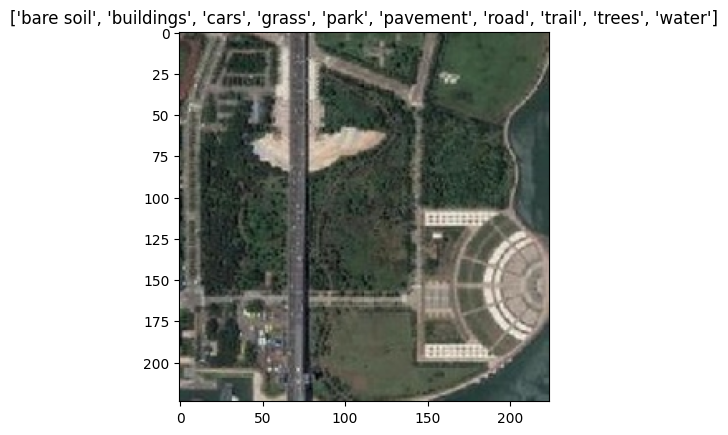

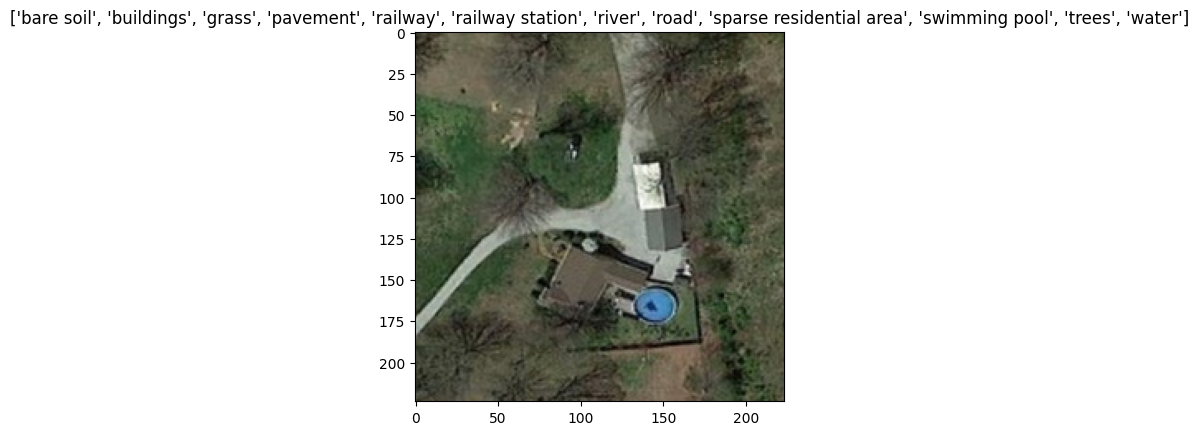

In [29]:
iter_train=iter(train_outlier_dataset)

for i in range(num_show_img):
    inputs, classes = next(iter_train)
    out = utils.make_grid(inputs)
    imshow(out, title=[train_outlier.columns.tolist()[i+2] for i in classes.nonzero(as_tuple=True)[0].tolist()])

Model Selection
=========

In [30]:
class EfficientNetV1(nn.Module):
    def __init__(self,num_classes=60):
        super(EfficientNetV1, self).__init__()
        self.backbone=EfficientNet.from_pretrained('efficientnet-b0')
        self.classifier=nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x=self.backbone(x)
        x=F.sigmoid(self.classifier(x))
        return x

Train & Validation
================

In [31]:
def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    criterion=nn.BCELoss().to(device)
    
    best_val_loss=float('inf')
    best_model=None

    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss=[]
        
        for imgs, labels in tqdm(iter(train_loader)):
            imgs=imgs.float().to(device)
            labels=labels.to(device)
            
            optimizer.zero_grad()
            
            output=model(imgs)
            loss=criterion(output,labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
            
        _val_loss=validation(model, criterion, val_loader, device)
        _train_loss=np.mean(train_loss)
        
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}], Val Loss :[{_val_loss:.5f}]')
            
        if best_val_loss > _val_loss:
            best_val_loss=_val_loss
            best_model=model
            
    return best_model


In [32]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss=[]
    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs=imgs.float().to(device)
            labels=labels.to(device)
            
            probs=model(imgs)
            loss=criterion(probs,labels)
            val_loss.append(loss.item())
        _val_loss=np.mean(val_loss)
        
    return _val_loss
            

In [33]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    predictions=[]
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs=imgs.float().to(device)
            
            probs=model(imgs)
            probs=probs.cpu().detach().numpy()
            predictions+=probs.tolist()
            
    return predictions

In [34]:
model=EfficientNetV1()
optimizer=torch.optim.Adam(params=model.parameters(),lr=CFG['LEARNING_RATE'])
infer_model=train(model, optimizer, train_loader, val_loader, device)

Loaded pretrained weights for efficientnet-b0


100%|██████████| 205/205 [00:54<00:00,  3.77it/s]


Epoch [1], Train Loss : [0.08246], Val Loss :[0.85571]


100%|██████████| 205/205 [00:53<00:00,  3.81it/s]


Epoch [2], Train Loss : [0.04831], Val Loss :[1.13438]


100%|██████████| 205/205 [00:54<00:00,  3.78it/s]


Epoch [3], Train Loss : [0.03902], Val Loss :[1.32055]


100%|██████████| 205/205 [00:53<00:00,  3.83it/s]


Epoch [4], Train Loss : [0.03362], Val Loss :[1.42192]


100%|██████████| 205/205 [02:36<00:00,  1.31it/s]

Epoch [5], Train Loss : [0.02920], Val Loss :[1.59407]


Predict & Submission
===================

In [35]:
path='./'

In [36]:
torch.save(infer_model.state_dict(), path+'efficientnetv4-lanczos4.pt')

In [37]:
test_dataset = CustomDataset(test['img_path'].values, None, aug_mode='normal', mode='test')
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [38]:
preds = inference(infer_model, test_loader, device)


100%|██████████| 683/683 [08:12<00:00,  1.39it/s]


In [39]:
submit = pd.read_csv('sample_submission.csv')
submit.iloc[:,1:] = preds
submit.head()

submit.to_csv('EfficientNetV4-lanczos4.csv', encoding='utf-8', index=False)